In [1]:
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
from scipy import optimize
from matplotlib import pyplot as plt
%matplotlib inline

## Line search algorithm

Finds the step $\alpha^*$ used in the <code>BFGS</code> algorithm in the direction given by <code>p</code>. The step needs to satisfy the strong Wolfe conditions.

In [4]:
def line_search_wolfe(fun, grad, x, p, maxiter=100, c1=10**(-3), c2=0.9, alpha_1=1.0, alpha_max=10**6):
    if alpha_1 >= alpha_max:
        raise ValueError('Argument alpha_1 should be less than alpha_max')
    
    def phi(alpha):
        return fun(x + alpha*p)
    
    def phi_grad(alpha):
        return np.dot(grad(x + alpha*p).T, p)
    
    alpha_old = 0
    alpha_new = alpha_1
    
    final_alpha = None
    
    for i in np.arange(1, maxiter+1):
        phi_alpha = phi(alpha_new)
        
        if (i == 1 and phi_alpha > phi(0) + c1*alpha_new*phi_grad(0)) or (i > 1 and phi_alpha >= phi(alpha_old)):
            final_alpha = zoom(x, p, phi, phi_grad, alpha_old, alpha_new, c1, c2)
            break
        
        phi_grad_alpha = phi_grad(alpha_new)
        
        if np.abs(phi_grad_alpha) <= -c2 * phi_grad(0):
            final_alpha = alpha_new
            break
        
        if phi_grad_alpha >= 0:
            final_alpha = zoom(x, p, phi, phi_grad, alpha_new, alpha_old, c1, c2)
            break
            
        alpha_old = alpha_new
        alpha_new = alpha_new + (alpha_max - alpha_new) * np.random.rand(1)
        
    if i == maxiter and final_alpha is None:
        return None

    return final_alpha

Auxiliary function <code>zoom</code> searches for the final value <code>alpha_j</code> in the range \[<code>alpha_lo</code>, <code>alpha_hi</code>\] that will be used as the optimal step $\alpha^*$.

In [5]:
def zoom(x, p, phi, phi_grad, alpha_lo, alpha_hi, c1, c2):
    
    while True:
        alpha_j = (alpha_hi + alpha_lo)/2
        
        phi_alpha_j = phi(alpha_j)
        
        if (phi_alpha_j > phi(0) + c1*alpha_j*phi_grad(0)) or (phi_alpha_j >= phi(alpha_lo)):
            alpha_hi = alpha_j
        else:
            phi_grad_alpha_j = phi_grad(alpha_j)
            
            if np.abs(phi_grad_alpha_j) <= -c2*phi_grad(0):
                return alpha_j
            
            if phi_grad_alpha_j*(alpha_hi - alpha_lo) >= 0:
                alpha_hi = alpha_lo
            
            alpha_lo = alpha_j

## BFGS algorithm

The main implementation of the BFGS algorithm.

In [6]:
def BFGS(fun, grad, x_start, eps, max_iterations=100, verbose=False):
    n = len(x_start)
    
    # We are starting with identity matrix 
    # as approximation of the inverse of the Hessian.
    # It will be updated on every iteration.
    # We are using the notation H_k = (B_k)^{-1},
    # where B_k is the approximation of the Hessian.
    H_old = np.diag(np.ones(n))
    x_old = x_start
    
    for i in np.arange(1, max_iterations+1):
        # Search direction
        p = -1*np.dot(H_old, grad(x_old))
        
        # Calculating the step into the direction p
        # using the Wolfe conditions as constrains on the step.
        alpha = line_search_wolfe(fun, grad, x_old, p, maxiter=max_iterations)
        
        if alpha is None:
            print('Wolfe line search did not converge')
            return x_old, i
        
        x_new = x_old + alpha*p
        
        s = (x_new - x_old).reshape((n, 1))
        y = (grad(x_new) - grad(x_old)).reshape((n, 1))
        sT = s.T.reshape((1, n))
        yT = y.T.reshape((1, n))
        
        yT_s = np.dot(yT, s).reshape(())
        
        I = np.diag(np.ones(n))
        rho = 1 / yT_s
        rho2 = rho**2
        
        # The next products are being used 
        # in the calculation of the H_{k+1} from H_k.
        # Only the matrices of dimension (n x n) will be used in the final formula.
        H_y         = np.dot(H_old,    y).reshape((n, 1)) # H_k * y_k
        Hy_sT       = np.dot(H_y,     sT).reshape((n, n)) # (H_k*y_k) * s^T
        yT_H        = np.dot(yT,   H_old).reshape((1, n)) # y_k^T * H_k
        s_yTH       = np.dot(s,     yT_H).reshape((n, n)) # s_k * (y_k^T*H_k)
        syTH_y      = np.dot(s_yTH,    y).reshape((n, 1)) # (s_k*(y_k^T*H_k)) * y_k
        syTHy_sT    = np.dot(syTH_y,  sT).reshape((n, n)) # ((s_k*(y_k^T*H_k))*y_k) * s_k^T
        s_sT        = np.dot(s,       sT).reshape((n, n)) # s_k * s_k^T
        
        # The initial formula 
        # H_{k+1} = (I - rho_k*s_k*y_k^T)H_k(I - rho_k*y_k*s_k^T) + rho_k*s_k*s_T
        # can be rewritten as 
        # H_{k+1} = H_k - rho_k*(H_k*y_k)*s_k^T - rho_k*s_k*(y_k^T*H_k) + rho_k^2*((s_k*(y_k^T*H_k))*y_k)*s_k^T + rho_k*s_k*s_k^T
        # to avoid calculations of assimptote complexity O(n^3).
        H_new = H_old - rho*Hy_sT - rho*s_yTH + rho2*syTHy_sT + rho*s_sT
        
        if verbose:
            print('x_k = {0} converges to x_(k+1) = {1}'.format(x_old, x_new))
        
        # We are using the 2-norm value 
        # between the previous and the next gradient
        # of the approximation of the function minima
        # as the stopping condition for the BFGS algorithm.
        grad_dist = np.linalg.norm(grad(x_old) - grad(x_new))
        if grad_dist < eps:
            break
        elif verbose:
            print('There is still {0} left for approximations to converge'.format(np.abs(grad_dist-eps)), '\n')
        
        x_old = x_new
        H_old = H_new
    
    if verbose:
        print('\nFinal approximation of the minima is {0}.'.format(x_new))
        if i != max_iterations:
            print('Optimization process converged in {0} steps'.format(i))
        else:
            print('Optimization process did not converge')
        
    return x_new, i

## Testing

In [7]:
def f(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    
    # local minima = (0, 5, 0)
    # no globam minima
    return x1**2 + (x2-5)**2 + x3**2 + np.sin(x1)**2

In [8]:
def grad_f(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    
    return np.array([2*x1 + 2*np.sin(x1)*np.cos(x1), 2*(x2-5), 2*x3])

In [9]:
def g(x):
    x1 = x[0]
    x2 = x[1]
    
    # global minima = (2/3, -5/3)
    return -(5 + 3*x1 - 4*x2 - x1**2 + x1*x2 - x2**2)

In [10]:
def grad_g(x):
    x1 = x[0]
    x2 = x[1]
    
    return np.array([2*x1 - x2 - 3, -x1 + 2*x2 + 4])

In [11]:
def h(x):
    x1 = x[0]
    x2 = x[1]
    
    # global minima = every (x,y) such that x^2+2y^2=4
    return (4 - x1**2 - 2*x2**2)**2

In [12]:
def grad_h(x):
    x1 = x[0]
    x2 = x[1]
    
    return np.array([-4*x1*(-x1**2 - 2*(x2**2) + 4), -8*x2*(-x1**2 -2*(x2**2) + 4)])

In [13]:
functions = np.array([f, g, h])
gradients = np.array([grad_f, grad_g, grad_h])
num_of_args = np.array([3, 2, 2])

In [14]:
n = len(functions)
number_of_executing = 50
number_of_algorithms = 2


Minimizing function f...



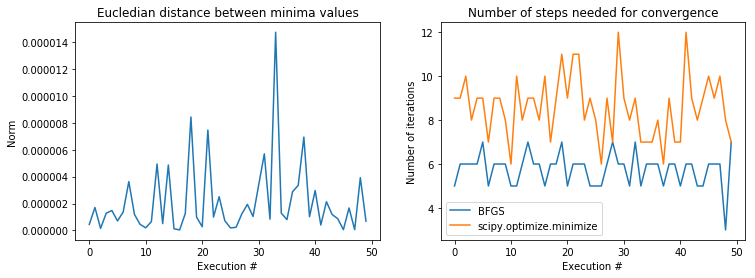


Minimizing function g...



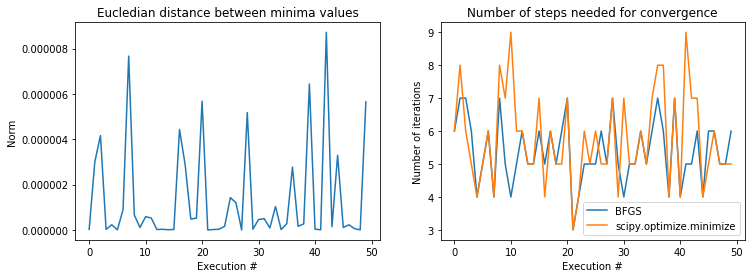


Minimizing function h...



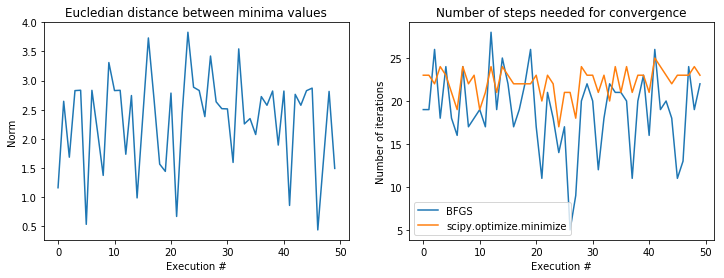

In [15]:
for i in np.arange(n):
    print('\nMinimizing function {0}...\n'.format(functions[i].__name__))
    
    minima_table = np.zeros(number_of_executing)
    execution_table = np.zeros((number_of_algorithms, number_of_executing))
    
    for j in np.arange(number_of_executing):
        x_start = np.random.randint(-100, 100, num_of_args[i])
        minima_0 = None
        
        for k in np.arange(number_of_algorithms):
            if k == 0:
                x_min, nit = BFGS(functions[i], gradients[i], x_start, 0.001, max_iterations=30, verbose=False)
                minima_0 = x_min
                execution_table[k][j] = nit
            elif k == 1:
                result = optimize.minimize(functions[i], x_start, method='BFGS', jac=gradients[i])
                minima_table[j] = np.linalg.norm(minima_0-result['x'])
                execution_table[k][j] = result['nit']
            else:
                raise ValueError('Attempting to start algorithm number {0}, which should not exist'.format(k))
    
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    
    ax0.set_title('Eucledian distance between minima values')
    ax0.plot(np.arange(number_of_executing), minima_table)
    ax0.set_xlabel('Execution #')
    ax0.set_ylabel('Norm')
    
    ax1.set_title('Number of steps needed for convergence')
    ax1.plot(np.arange(number_of_executing), execution_table[0], label='BFGS')
    ax1.plot(np.arange(number_of_executing), execution_table[1], label='scipy.optimize.minimize')
    ax1.set_xlabel('Execution #')
    ax1.set_ylabel('Number of iterations')
    ax1.legend(loc='best')
    
    plt.show()